In [16]:
!pip install matplotsoccer


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Arnau Climent\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


  Using cached matplotsoccer-0.0.8-py3-none-any.whl


In [3]:
import os
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")
import tqdm
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Use this if you want to use the free public statsbomb data
# or provide credentials to access the API
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

# # Uncomment the code below if you have a local folder on your computer with statsbomb data
# datafolder = "../data/statsbomb-epl-1718" # Example of local folder with statsbomb data
# SBL = StatsBombLoader(root=datafolder, getter="local")

In [5]:
# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

{'1. Bundesliga',
 'African Cup of Nations',
 'Champions League',
 'Copa America',
 'Copa del Rey',
 "FA Women's Super League",
 'FIFA U20 World Cup',
 'FIFA World Cup',
 'Indian Super league',
 'La Liga',
 'Liga Profesional',
 'Ligue 1',
 'Major League Soccer',
 'NWSL',
 'North American League',
 'Premier League',
 'Serie A',
 'UEFA Euro',
 'UEFA Europa League',
 "UEFA Women's Euro",
 "Women's World Cup"}

In [6]:

selected_competitions = competitions[
    (competitions.competition_name == "La Liga")
    & (competitions.season_name == "2020/2021")
]

# # Messi data
# selected_competitions = competitions[competitions.competition_name == "La Liga"]

# # FA Women's Super League
# selected_competitions = competitions[competitions.competition_name == "FA Women's Super League"]

selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
38,90,11,La Liga,Spain,male,2020/2021


In [7]:
# Get games from all selected competitions
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,206,217,2020-10-31 21:00:00,1,1
1,1049,217,2021-01-09 18:30:00,0,4
2,217,209,2021-05-16 18:30:00,1,2
3,218,217,2021-02-07 21:00:00,2,3
4,422,217,2021-03-06 21:00:00,0,2
5,220,217,2021-04-10 21:00:00,2,1
6,217,221,2020-12-13 21:00:00,1,0
7,217,222,2020-09-27 21:00:00,4,0
8,209,217,2020-10-01 21:30:00,0,3
9,217,220,2020-10-24 16:00:00,1,3


## Load and convert match data

In [8]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    # convert data
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(
        events, 
        home_team_id=game.home_team_id,
        xy_fidelity_version=1,
        shot_fidelity_version=1
    )

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data:   0%|                                                                        | 0/35 [00:00<?, ?it/s]C:\Users\Arnau Climent\AppData\Local\Programs\Python\Python311\Lib\site-packages\socceraction\data\statsbomb\loader.py:337: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventsdf["under_pressure"] = eventsdf["under_pressure"].fillna(False).astype(bool)
C:\Users\Arnau Climent\AppData\Local\Programs\Python\Python311\Lib\site-packages\socceraction\data\statsbomb\loader.py:338: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventsdf["counterp

## Store converted spadl data in a h5-file

In [11]:
datafolder = "C:\\Users\\Arnau Climent\\OneDrive\\Documentos\\1_MASTER\\PORTFOLIO\\futbol-data-visualizacion\\archivos"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

## Plot the spadl data

In [12]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select game
    game = games[(games.competition_name == "La Liga") 
                  & (games.away_team_name == "Barcelona")
                  & (games.home_team_name == "Villarreal")]
    game_id = game.game_id.values[0]
    actions = (
        spadlstore[f"actions/game_{game_id}"]
        .merge(spadl.actiontypes_df(), how="left")
        .merge(spadl.results_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)
del actions['nickname']
actions[:5]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
0,3773689,11cc18ab-1d15-4b2f-be66-b481f23ca65c,1,1.456,222,6402.0,52.9375,34.340,52.7625,32.385,0,1,5,0,pass,success,foot_right,Paco Alcácer,Villarreal
1,3773689,4ec18d2e-5ac1-4428-a983-444f6b285293,1,2.423,222,6766.0,52.7625,32.385,53.9000,32.215,21,1,0,1,dribble,success,foot,Gerard Moreno,Villarreal
2,3773689,c8b088ce-a6f5-48f8-b45d-e26e4d9cdd85,1,2.825,222,6766.0,53.9000,32.215,43.8375,44.540,0,1,4,2,pass,success,foot_left,Gerard Moreno,Villarreal
3,3773689,291deca2-fa52-4581-8b80-59e55a13ed72,1,4.194,222,6595.0,43.8375,44.540,41.5625,44.030,21,1,0,3,dribble,success,foot,Dani Parejo,Villarreal
4,3773689,9090169f-feff-45b2-a848-d257370ed0bb,1,5.827,222,6595.0,41.5625,44.030,27.6500,35.360,0,1,5,4,pass,success,foot_right,Dani Parejo,Villarreal


In [13]:
print(actions.columns)

print(actions["type_name"].unique())






Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'player_name', 'team_name'],
      dtype='object')
['pass' 'dribble' 'throw_in' 'take_on' 'corner_crossed' 'shot' 'goalkick'
 'tackle' 'bad_touch' 'interception' 'cross' 'clearance' 'keeper_punch'
 'foul' 'shot_freekick' 'freekick_short' 'keeper_save' 'freekick_crossed'
 'corner_short']


In [14]:
goals = actions[(actions["type_name"] == "shot") & (actions["result_name"] == "success")]
print(goals[["player_name", "team_name", "time_seconds", "start_x", "start_y", "end_x", "end_y"]])


           player_name   team_name  time_seconds   start_x  start_y     end_x  \
687   Samuel Chukwueze  Villarreal      1560.516  100.4500   42.500  104.5625   
693  Antoine Griezmann   Barcelona      1646.398    8.9250   44.880    0.4375   
880  Antoine Griezmann   Barcelona      2071.201   12.8625   29.835    0.4375   

       end_y  
687  34.3825  
693  31.3225  
880  36.3375  


2021-04-25 16:15:00 Villarreal 1-2 Barcelona 35'


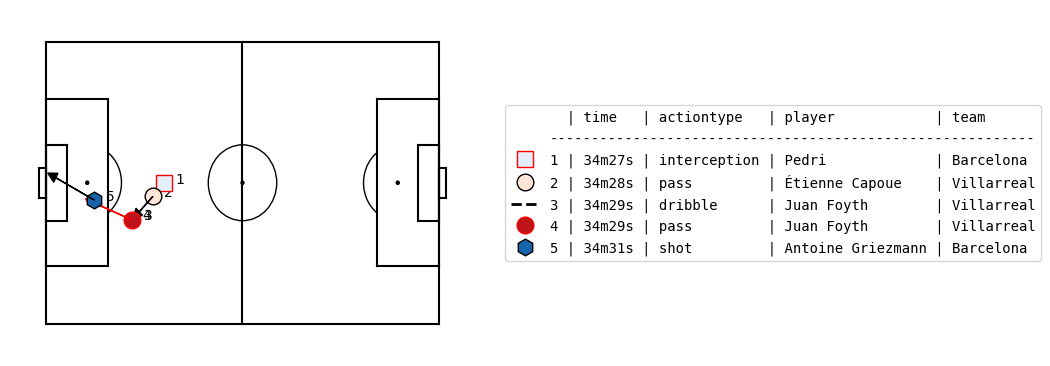

In [17]:
import matplotsoccer

shot = 880
a = actions[shot-4:shot+1].copy()

# Print the game date and timestamp of the goal 1-2 35' griezmann
g = game.iloc[0]
minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(game_info)

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name"]]

ax = matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False,
    figsize=6
)